# DEA Coastlines vector statistics <img align="right" src="https://github.com/GeoscienceAustralia/dea-notebooks/raw/develop/Supplementary_data/dea_logo.jpg">

This code conducts vector subpixel shoreline extraction for DEA Coastlines:

* Apply morphological extraction algorithms to mask annual median composite rasters to a valid coastal region
* Extract waterline vectors using subpixel waterline extraction ([Bishop-Taylor et al. 2019b](https://doi.org/10.3390/rs11242984))
* Compute rates of coastal change at every 30 m using linear regression

This is an interactive version of the code intended for prototyping; to run this analysis at scale, use the [command line tools](DEACoastlines_generation_CLI.ipynb).


---

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-coastlines


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [2]:
pip install -r requirements.in --quiet

You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from rasterio.transform import array_bounds
from dea_tools.spatial import subpixel_contours

# Load DEA Coastlines code
import coastlines.raster
import coastlines.vector

# Hide Pandas warnings
pd.options.mode.chained_assignment = None

## Load in data

In [55]:
study_area = 6727
raster_version = "testing"
vector_version = "testing"
water_index = "mndwi"
index_threshold = 0.00
start_year = 1988
end_year = 2021
baseline_year = 2021

# Load analysis params from config file
config = coastlines.raster.load_config(
    config_path="configs/dea_coastlines_config.yaml"
)

## Load DEA Coastlines rasters

In [5]:
yearly_ds, gapfill_ds = coastlines.vector.load_rasters(
    path="data/interim/raster",
    raster_version=raster_version,
    study_area=study_area,
    water_index=water_index,
    start_year=start_year,
    end_year=end_year,
)
print(yearly_ds)

# Create output vector folder
output_dir = f"data/interim/vector/{vector_version}/{study_area}_{vector_version}"
os.makedirs(output_dir, exist_ok=True)

<xarray.Dataset>
Dimensions:  (year: 34, y: 2131, x: 2063)
Coordinates:
  * year     (year) int64 1988 1989 1990 1991 1992 ... 2017 2018 2019 2020 2021
  * y        (y) float64 -4.79e+06 -4.79e+06 -4.79e+06 ... -4.853e+06 -4.853e+06
  * x        (x) float64 3.938e+05 3.938e+05 3.938e+05 ... 4.556e+05 4.556e+05
Data variables:
    mndwi    (year, y, x) float32 nan nan nan nan ... 0.354 0.2901 0.2622 0.2992
    ndwi     (year, y, x) float32 nan nan nan nan ... 0.1595 0.1421 0.1226
    tide_m   (year, y, x) float32 -0.01526 -0.01527 -0.01527 ... 0.02845 0.02849
    count    (year, y, x) int16 0 0 0 0 0 0 0 0 0 ... 15 15 16 15 15 15 15 15 15
    stdev    (year, y, x) float32 nan nan nan nan ... 0.2011 0.2606 0.2075
Attributes:
    transform:      | 30.00, 0.00, 393765.00|\n| 0.00,-30.00,-4789515.00|\n| ...
    crs:            +init=epsg:32655
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_P

## Load vector data

In [56]:
# Get bounding box to load data for
bbox = gpd.GeoSeries(
    box(
        *array_bounds(
            height=yearly_ds.sizes["y"],
            width=yearly_ds.sizes["x"],
            transform=yearly_ds.transform,
        )
    ),
    crs=yearly_ds.crs,
)

# Tide points
tide_points_gdf = gpd.read_file(config["Input files"]["points_path"], bbox=bbox).to_crs(
    yearly_ds.crs
)

# Study area polygon
gridcell_gdf = (
    gpd.read_file(config["Input files"]["grid_path"], bbox=bbox)
    .set_index("id")
    .to_crs(str(yearly_ds.crs))
)
gridcell_gdf.index = gridcell_gdf.index.astype(int).astype(str)
gridcell_gdf = gridcell_gdf.loc[[str(study_area)]]

# # Coastal mask modifications
# modifications_gdf = gpd.read_file(
#     config["Input files"]["modifications_path"], bbox=bbox
# ).to_crs(str(yearly_ds.crs))

# Geomorphology dataset
geomorphology_gdf = gpd.read_file(
    config["Input files"]["geomorphology_path"], bbox=bbox
).to_crs(str(yearly_ds.crs))

# Region attribute dataset
region_gdf = gpd.read_file(
    config["Input files"]["region_attributes_path"], bbox=bbox
).to_crs(str(yearly_ds.crs))

## Extract annual shorelines

### Restrict annual shorelines to coastal study area

In [7]:
# Mask dataset to focus on coastal zone only
masked_ds, certainty_masks = coastlines.vector.contours_preprocess(
    yearly_ds,
    gapfill_ds,
    water_index,
    index_threshold,
    tide_points_gdf,
    buffer_pixels=33,
    mask_landcover=False,
    mask_modifications=None, # modifications_gdf,
)

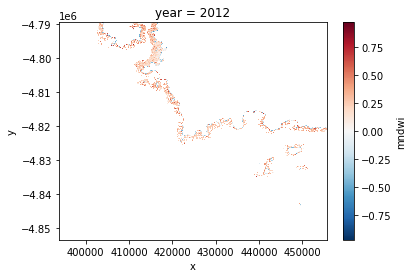

In [17]:
# masked_ds.isel(year=-10).plot.imshow()

In [18]:
import skimage
skimage.__version__

'0.18.3'

In [63]:
# Extract contours
contours_gdf = subpixel_contours(
    da=masked_ds,
    z_values=index_threshold+1e-12,
    min_vertices=10,
    dim="year",
    output_path=f"temp.geojson",
).set_index("year")

## Compute statistics
### Create stats points on baseline contour

In [20]:
# Extract statistics modelling points along baseline contour
points_gdf = coastlines.vector.points_on_line(contours_gdf, str(baseline_year), distance=30)

### Measure annual coastline movements

In [21]:
if points_gdf is not None and len(points_gdf) > 0:

    # Calculate annual movements and residual tide heights for every
    # contour compared to the baseline year
    points_gdf = coastlines.vector.annual_movements(
        points_gdf,
        contours_gdf,
        yearly_ds,
        str(baseline_year),
        water_index,
        max_valid_dist=5000,
    )

### Calculate regressions

In [22]:
if points_gdf is not None and len(points_gdf) > 0:

    # Apply regression function to each row in dataset
    points_gdf = coastlines.vector.calculate_regressions(points_gdf, contours_gdf)

# Add count and span of valid obs, Shoreline Change Envelope (SCE),
# Net Shoreline Movement (NSM) and Max/Min years
stats_list = ["valid_obs", "valid_span", "sce", "nsm", "max_year", "min_year"]
points_gdf[stats_list] = points_gdf.apply(
    lambda x: coastlines.vector.all_time_stats(x, initial_year=start_year), axis=1
)

### Add certainty flags
Add certainty column to flag points with:
- Likely rocky shorelines: Rates of change can be unreliable in areas with steep rocky/bedrock shorelines due to terrain shadow.
- Extreme rate of change value (> 50 m per year change) that is more likely to reflect modelling issues than real-world coastal change
- High angular variability: the nearest shorelines for each year do not fall on an approximate line, making rates of change invalid
- Insufficient observations: less than 25 valid annual shorelines, which make the resulting rates of change more likely to be inaccurate

In [52]:
rocky = [
    "Bedrock breakdown debris (cobbles/boulders)",
    "Boulder (rock) beach",
    "Cliff (>5m) (undiff)",
    "Colluvium (talus) undiff",
    "Flat boulder deposit (rock) undiff",
    "Hard bedrock shore",
    "Hard bedrock shore inferred",
    "Hard rock cliff (>5m)",
    "Hard rocky shore platform",
    "Rocky shore (undiff)",
    "Rocky shore platform (undiff)",
    "Sloping hard rock shore",
    "Sloping rocky shore (undiff)",
    "Soft `bedrock¿ cliff (>5m)",
    "Steep boulder talus",
    "Hard rocky shore platform",
]

# Initialise certainty column with good values
points_gdf["certainty"] = "good"

# Flag rocky shorelines
points_gdf.loc[
    coastlines.vector.rocky_shoreline_flag(
        points_gdf,
        geomorphology_gdf,
        rocky_query=f"(INTERTD1_V in {rocky}) & (INTERTD2_V in {rocky + ['Unclassified']})",
    ),
    "certainty",
] = "likely rocky coastline"

# Flag extreme rates of change
points_gdf.loc[
    points_gdf.rate_time.abs() > 50, "certainty"
] = "extreme value (> 50 m)"

# Flag points where change does not fall on a line
points_gdf.loc[points_gdf.angle_std > 30, "certainty"] = "high angular variability"

# Flag shorelines with less than X valid shorelines
points_gdf.loc[points_gdf.valid_obs < 25, "certainty"] = "insufficient observations"

### Add region attributes

In [61]:
points_gdf = coastlines.vector.region_atttributes(
    points_gdf, region_gdf, attribute_col="ID_Primary", rename_col="id_primary"
)

## Export files

### Export stats files

In [50]:
if points_gdf is not None:

    # Set up scheme to optimise file size
    schema_dict = {key: "float:8.2" for key in points_gdf.columns if key != "geometry"}
    schema_dict.update(
        {
            "sig_time": "float:8.3",
            "outl_time": "str:80",
            "angle_mean": "int:3",
            "angle_std": "int:3",
            "valid_obs": "int:4",
            "valid_span": "int:4",
            "max_year": "int:4",
            "min_year": "int:4",
            "certainty": "str:25",
            "id_primary": "str:10",
        }
    )
    col_schema = schema_dict.items()

    # Clip stats to study area extent
    stats_path = (
        f"{output_dir}/ratesofchange_{study_area}_"
        f"{vector_version}_{water_index}_{index_threshold:.2f}"
    )
    points_gdf = points_gdf[points_gdf.intersects(gridcell_gdf.geometry.item())]

    # Export to GeoJSON
    points_gdf.to_crs("EPSG:4326").to_file(f"{stats_path}.geojson", driver="GeoJSON")

    # Export as ESRI shapefiles
    points_gdf.to_file(
        f"{stats_path}.shp", schema={"properties": col_schema, "geometry": "Point"}
    )

### Export annual shorelines

In [64]:
# Assign certainty to contours based on underlying masks
contours_gdf = coastlines.vector.contour_certainty(contours_gdf, certainty_masks)

# Add tide datum details (this supports future addition of extra tide datums)
contours_gdf["tide_datum"] = "0 m AMSL (approx)"

# Add region attributes
contours_gdf = coastlines.vector.region_atttributes(
    contours_gdf, region_gdf, attribute_col="ID_Primary", rename_col="id_primary"
)

# Clip annual shoreline contours to study area extent
contour_path = (
    f"{output_dir}/annualshorelines_{study_area}_{vector_version}_"
    f"{water_index}_{index_threshold:.2f}"
)
contours_gdf["geometry"] = contours_gdf.intersection(gridcell_gdf.geometry.item())
contours_gdf.reset_index().to_crs("EPSG:4326").to_file(
    f"{contour_path}.geojson", driver="GeoJSON"
)

# Export stats and contours as ESRI shapefiles
contours_gdf.reset_index().to_file(f"{contour_path}.shp")

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** For assistance with any of the Python code or Jupyter Notebooks in this repository, please post a [Github issue](https://github.com/GeoscienceAustralia/dea-coastlines/issues/new).

**Last modified:** July 2022